<a href="https://colab.research.google.com/github/karencfisher/face_express/blob/main/notebooks/conv_model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The initial dataset is from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The ```icml_face_data.csv``` (AKA ```fer2013```) dataset which contains a total of 34034 samples. It contains 3 columns. The target label is an integer (0, 6), the eight basic emtions:

```
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
```

The labels are updated to 8 basic categories based on crowd sourcing by a group of researchers at Microsoft Research perceiving that the original fer2013 dataset had wildly inaccurate labels. As often facial expressions, by even human performance, can be ambiguous, they had 10 labellers vote on 8 basic emotions (omitting 'unkown'):

```
['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']
```

They have published a revised dataset ```fer2013new.csv``` (https://github.com/microsoft/FERPlus/blob/master/fer2013new.csv), with consistency row-wise between the new and original datasets, which we will incorporate here. We can later map between the two sets of labels to evaluate the differences in performance.

We will use the newer labelling here updating the original dataset labels. Assuming that 'disgust' and 'contempt' are close if not exactly synonymous, we can reduce this set of labels to the original 7 classes in the original fer2013 dataset. To do so we credit any 'votes' to 'contempt' to 'disgust'.We can then see if improved labelling improves the model performance.

One strategy to then is to use the 'majority rule', as followed here. Given the votes on the 7 classes, we choose the argmax of them as the ground truth for that sample. Other strategies include the ground truth be not a single classification, but rather a probability distribution based on the 'voting.' We may then approximate more nuanced mixtures of the seven basic emotions, as building a color pallete from various mixtures of primary colors. 

###Preprocessing

The images are stored in the 'pixels' column, as a string of 2304 integer values (0, 255) separated by spaces. These will need be coverted into an array of integer values. Subsequently, they will be needs reshaped into 3-d numpy arrays to be input to the CNN.

We then concatenate the two datasets column-wise. Combining them together in this way will expedite removing a small percentage of missing values in the newly labelled dataset (approximately 0.5% of the samples).



In [3]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    return df

In [4]:
df = loadCleanData('/content/drive/MyDrive/face express data/icml_face_data.csv')
df.head()

,emotion,usage,pixels
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [5]:
df_labels = pd.read_csv('https://raw.githubusercontent.com/microsoft/FERPlus/master/fer2013new.csv')
df_labels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


In [6]:
df_labels = df_labels[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']]
fer2013_new = pd.concat([df, df_labels], axis=1)

The ```fer2013_new``` label set however has a number of missing values (NF or 'No File' == 10). As these samples (176 examples, 0.5% of the data) were then dropped from the dataset. We then disregard the NF column and 'unknown' columns.

In [7]:
fer2013_new.head()

,emotion,usage,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0


In [8]:
fer2013_new = fer2013_new[fer2013_new['NF'] < 10]
fer2013_new.shape

(35711, 13)

In [9]:
# Select all but NF for use
y = fer2013_new[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values

In [10]:
# Majority rule
def makeClasses(votes):
  probs = []
  for row in range(votes.shape[0]):
    # put any contempt votes to disgust
    votes[row][5] += votes[row][7]
    y = np.argmax(votes[row][:7])
    probs.append(y)

  return np.array(probs)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

Split into training and testing sets.

In [35]:
x_train, x_test, y_train, y_test = train_test_split(fer2013_new['pixels'],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28568,), (7143,), (28568, 8), (7143, 8))

Normalize the image data to in range (0, 1). We will also first have to transform lists of integers to a 2-d numpy array, and then reshape that into the 4-d array (m, h, w, c) as neede by the convolutional layers.

In [36]:
# transform lists of integers into numpy arrays, and normalize the values
x_train = np.vstack(x_train) / 255
x_test = np.vstack(x_test) / 255

# reshape arrays into (m, h, w, c). As they are square, we can get the height
# and width values as a square root of the length the original 1-d array.
n = int(np.sqrt(x_train.shape[1]))
x_train = x_train.reshape(x_train.shape[0], n, n, 1)
x_test = x_test.reshape(x_test.shape[0], n, n, 1)

# Convert the pandas series of target classes to numpy array of majority cases
y_train = makeClasses(y_train)
y_test = makeClasses(y_test)

###Building the CNN

The model here is inspired by the VGGNet architecture. 

In [39]:
model = Sequential([Conv2D(64, (3, 3), input_shape=x_train.shape[1:], activation='relu'),
                    BatchNormalization(),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(512, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(512, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((2, 2), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.5),
                    Dense(256, activation='relu'),
                    Dropout(0.5),
                    Dense(64, activation='relu'),
                    Dropout(0.5),
                    Dense(7, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 22, 128)      

###Training the model. 

Employing also early stopping, model checkpoint, and learning rate adjustment to avoid plateaus in the gradient descent.

In [40]:
stop = EarlyStopping(monitor='val_acc', patience=6, restore_best_weights=True)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/face express data/weights.h5', 
                             monitor='val_acc', save_best_only=True, 
                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

history = model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=100,
          batch_size=128,
          callbacks=[stop, checkpoint, reduce_lr])

Epoch 1/100
224/224 [==============================] - 17s 77ms/step - loss: 1.8708 - acc: 0.3102 - val_loss: 1.6236 - val_acc: 0.3583
Epoch 2/100
224/224 [==============================] - 17s 74ms/step - loss: 1.6300 - acc: 0.3613 - val_loss: 1.6386 - val_acc: 0.3583
Epoch 3/100
224/224 [==============================] - 17s 77ms/step - loss: 1.5325 - acc: 0.4060 - val_loss: 1.4456 - val_acc: 0.4206
Epoch 4/100
224/224 [==============================] - 17s 76ms/step - loss: 1.4180 - acc: 0.4702 - val_loss: 1.3830 - val_acc: 0.5019
Epoch 5/100
224/224 [==============================] - 17s 75ms/step - loss: 1.2554 - acc: 0.5734 - val_loss: 1.2564 - val_acc: 0.5681
Epoch 6/100
224/224 [==============================] - 17s 74ms/step - loss: 1.1300 - acc: 0.6244 - val_loss: 1.3210 - val_acc: 0.5037
Epoch 7/100
224/224 [==============================] - 17s 76ms/step - loss: 1.0440 - acc: 0.6601 - val_loss: 1.0432 - val_acc: 0.6396
Epoch 8/100
224/224 [==============================] - 

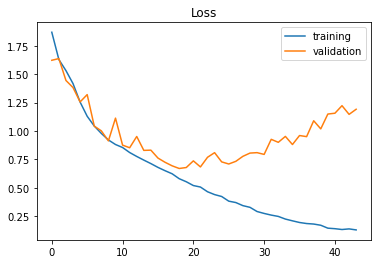

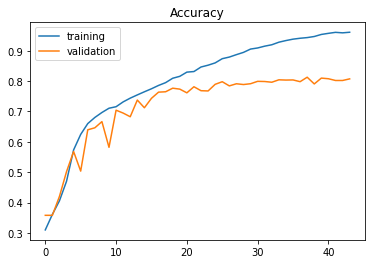

In [41]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

In [42]:
model.save('/content/drive/MyDrive/face express data/model2.h5')

Alternatively, load a model that has been trained and saved.

In [43]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/face express data/model2.h5')


In [44]:
preds = model.predict(x_test)
y_pred = [np.argmax(pred) for pred in preds]
score = accuracy_score(y_test, y_pred)
print(f'Accuracy = {round(score * 100, 2)} %')

Accuracy = 81.27 %


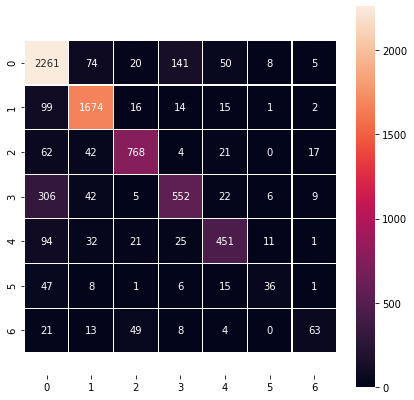

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

{'Neutral': 2559, 'Happy': 1821, 'Surprise': 914, 'Sad': 942, 'Angry': 635, 'Disgust': 114, 'Fear': 158}


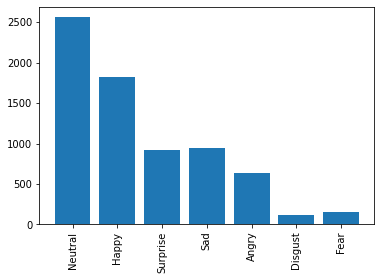

In [46]:
classes = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

y_count = np.bincount(y_test)
labels = {classes[i]: y_count[i] for i in range(len(classes))}
print(labels)
plt.bar(classes, y_count)
plt.xticks(rotation=90);

Perform inference on a random selected sample from the test dataset

In [47]:
def tryRandomExample():
    index = np.random.randint(0, x_test.shape[0])
    img = x_test[index]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    best = np.argmax(pred[0])
    
    print(classes[best] == classes[y_test[index]])
    print(f'Predicted label: {classes[best]}\nConfidence: {round(pred[0][best] * 100, 2)} %')
    print(f'Actual label: {classes[y_test[index]]}')
    
    plt.imshow(np.squeeze(img[0], axis=-1), cmap='gray')
    plt.show()
    
    df = pd.DataFrame(dict(probs=list(pred[0]), labels=classes))
    fig = px.line_polar(df, r='probs', theta='labels', line_close=True)
    fig.show()
    
    

### Try the model out

As the only reall proof of a model's worth is if it can infer examples. Here we are just randomly selecting from the test dataset. 

True
Predicted label: Happy
Confidence: 99.52 %
Actual label: Happy


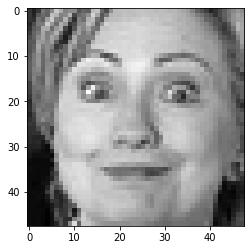

In [48]:
tryRandomExample()

### Try other images from the web

In [25]:
import cv2
import dlib
from imutils import resize, face_utils

detector = dlib.get_frontal_face_detector()
classes = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']


def predictEmotion(image):
  image = cv2.imread(image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)

  for rect in rects:
    img = gray[rect.top(): rect.bottom() + 1, rect.left(): rect.right() + 1]
    img = resize(img, width=48, height=48) / 255
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)

    probs = model.predict(img)
    predict = np.argmax(probs[0])
    prob = probs[0][predict]

    caption = f'{classes[predict]} {str(round(prob * 100))} %'
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    fontScale = min(w, h) / 200
    thickness = min(w, h) // 75
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), thickness) 
    cv2.putText(image, caption,(x - 10, y - 10),
		        cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 0, 255), thickness)

  plt.figure(figsize=(10,15))
  plt.imshow(image)
  plt.xlabel(f'{probs}')
  return image

In [26]:
!wget https://comps.canstockphoto.com/surprise-face-of-amazed-woman-stock-photography_csp34556509.jpg

--2020-11-25 20:57:49--  https://comps.canstockphoto.com/surprise-face-of-amazed-woman-stock-photography_csp34556509.jpg
Resolving comps.canstockphoto.com (comps.canstockphoto.com)... 205.185.216.10, 205.185.216.42
Connecting to comps.canstockphoto.com (comps.canstockphoto.com)|205.185.216.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24020 (23K) [image/jpeg]
Saving to: ‘surprise-face-of-amazed-woman-stock-photography_csp34556509.jpg’

surprise-face-of-am 100%[===================>]  23.46K  --.-KB/s    in 0s      

2020-11-25 20:57:49 (218 MB/s) - ‘surprise-face-of-amazed-woman-stock-photography_csp34556509.jpg’ saved [24020/24020]



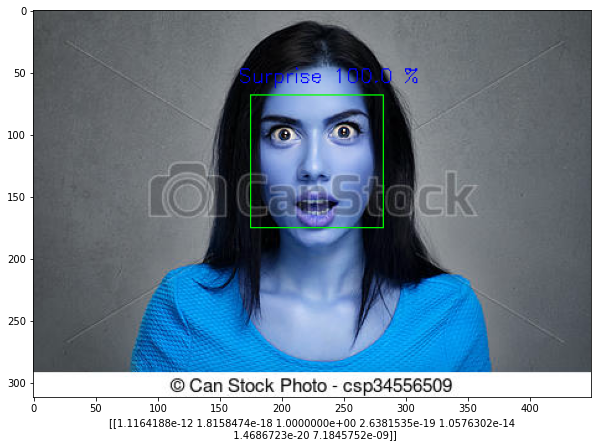

In [49]:
image = predictEmotion('surprise-face-of-amazed-woman-stock-photography_csp34556509.jpg')

In [ ]:
cv2.imwrite('surprise.jpg', image)

True

In [28]:
!wget https://previews.123rf.com/images/fredgoldstei/fredgoldstei0509/fredgoldstei050900052/242174-woman-with-sad-face.jpg

--2020-11-25 20:57:59--  https://previews.123rf.com/images/fredgoldstei/fredgoldstei0509/fredgoldstei050900052/242174-woman-with-sad-face.jpg
Resolving previews.123rf.com (previews.123rf.com)... 104.111.90.201
Connecting to previews.123rf.com (previews.123rf.com)|104.111.90.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117847 (115K) [image/jpeg]
Saving to: ‘242174-woman-with-sad-face.jpg’

242174-woman-with-s 100%[===================>] 115.08K  --.-KB/s    in 0.005s  

2020-11-25 20:57:59 (22.0 MB/s) - ‘242174-woman-with-sad-face.jpg’ saved [117847/117847]



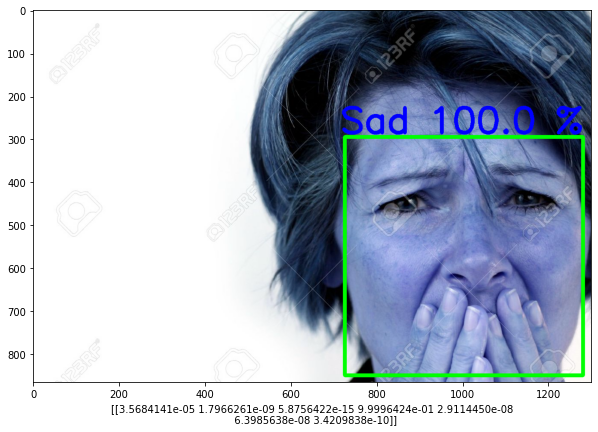

In [50]:
image = predictEmotion('242174-woman-with-sad-face.jpg')

In [30]:
cv2.imwrite('fear.jpg', image)

True

In [31]:
!wget https://www.pngfind.com/pngs/m/23-239534_our-smileys-for-your-business-u2013-because-happy.png

--2020-11-25 20:58:19--  https://www.pngfind.com/pngs/m/23-239534_our-smileys-for-your-business-u2013-because-happy.png
Resolving www.pngfind.com (www.pngfind.com)... 173.208.137.67
Connecting to www.pngfind.com (www.pngfind.com)|173.208.137.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274867 (268K) [image/png]
Saving to: ‘23-239534_our-smileys-for-your-business-u2013-because-happy.png’

23-239534_our-smile 100%[===================>] 268.42K  --.-KB/s    in 0.1s    

2020-11-25 20:58:20 (1.91 MB/s) - ‘23-239534_our-smileys-for-your-business-u2013-because-happy.png’ saved [274867/274867]



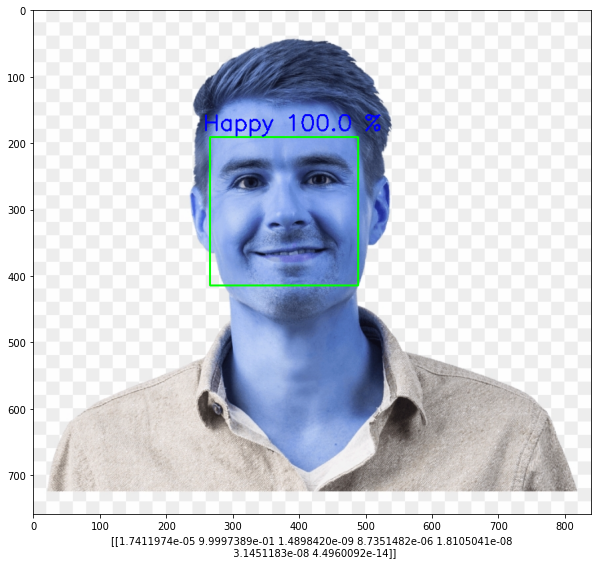

In [51]:
image = predictEmotion('23-239534_our-smileys-for-your-business-u2013-because-happy.png')

In [ ]:
cv2.imwrite('happy.jpg', image)

True

In [33]:
!wget https://st3.depositphotos.com/3591429/15874/i/1600/depositphotos_158742280-stock-photo-set-of-diversity-people-with.jpg

--2020-11-25 20:58:29--  https://st3.depositphotos.com/3591429/15874/i/1600/depositphotos_158742280-stock-photo-set-of-diversity-people-with.jpg
Resolving st3.depositphotos.com (st3.depositphotos.com)... 104.127.190.252
Connecting to st3.depositphotos.com (st3.depositphotos.com)|104.127.190.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348380 (340K) [image/jpeg]
Saving to: ‘depositphotos_158742280-stock-photo-set-of-diversity-people-with.jpg’

depositphotos_15874 100%[===================>] 340.21K  --.-KB/s    in 0.008s  

2020-11-25 20:58:29 (40.1 MB/s) - ‘depositphotos_158742280-stock-photo-set-of-diversity-people-with.jpg’ saved [348380/348380]



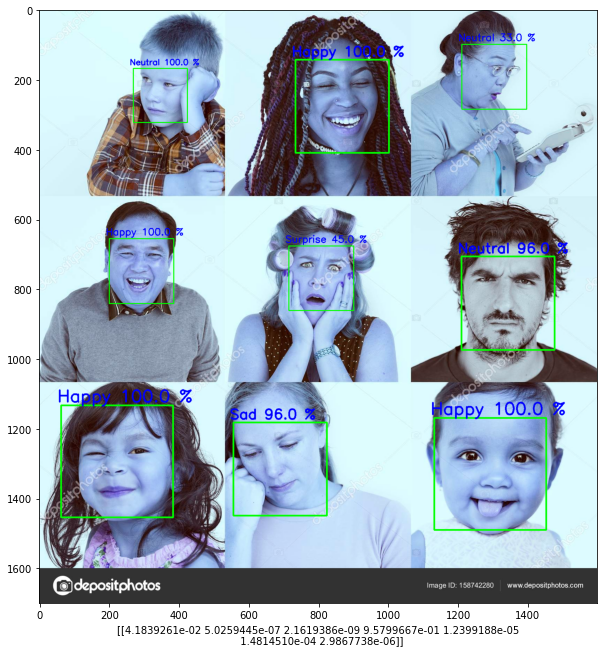

In [52]:
image = predictEmotion('depositphotos_158742280-stock-photo-set-of-diversity-people-with.jpg')

In [53]:
cv2.imwrite('image.jpg', image)

True